In [8]:
import nltk
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import sys
import pandas as pd
import csv

# Increase field size limit
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

# Define chunk size and sampling ratio
CHUNK_SIZE = 100000  # Read 100,000 rows at a time
SAMPLE_RATIO = 0.10  # Extract 10% of total data

sampled_chunks = []

for chunk in pd.read_csv("data/news.csv/news.csv", usecols=["content"], dtype=str, encoding="utf-8",
                         on_bad_lines="skip", low_memory=True, chunksize=CHUNK_SIZE, engine="python"):
    chunk_sample = chunk.sample(frac=SAMPLE_RATIO, random_state=42)  # Sample 10% of each chunk
    sampled_chunks.append(chunk_sample)

# Combine all sampled chunks
df_sampled = pd.concat(sampled_chunks, ignore_index=True)

print(f" Final Sampled Dataset Size: {len(df_sampled)} rows")  

 Final Sampled Dataset Size: 852909 rows


In [10]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter

# Initialize stopwords and stemmer
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# 🔹 Function to Compute Vocabulary Size in Chunks
def get_vocabulary_size(text_series, chunk_size=5000):
    vocab = Counter()  # Counter to store word frequencies
    for i in range(0, len(text_series), chunk_size):
        chunk_tokens = []
        
        # Tokenize each text in the chunk
        for text in text_series[i:i + chunk_size]:
            if text:  # Check if the text is not None or empty
                tokens = word_tokenize(text)  # Tokenize each text
                tokens = [token.lower() for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens and convert to lowercase
                chunk_tokens.extend(tokens)  # Add tokens to the chunk_tokens list
        
        # Update vocabulary with tokens from this chunk
        vocab.update(chunk_tokens)
    
    return len(vocab)  # Return the vocabulary size

# Compute initial vocabulary size (before processing)
vocab_size_before = get_vocabulary_size(df_sampled['content'])

print(f" Initial Vocabulary Size: {vocab_size_before}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


 Initial Vocabulary Size: 1116207


In [11]:
# 🔹 Remove null values from the 'content' column
df_sampled = df_sampled.dropna(subset=['content'])

# 🔹 Function to Preprocess Text: Remove stopwords and apply stemming
def preprocess_text(text):
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [token.lower() for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens and convert to lowercase
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming
    return tokens

# 🔹 Function to Compute Vocabulary Size After Preprocessing
def get_vocabulary_size_processed(text_series, chunk_size=5000):
    vocab = Counter()
    for i in range(0, len(text_series), chunk_size):
        chunk_tokens = [preprocess_text(text) for text in text_series[i:i + chunk_size]]
        for tokens in chunk_tokens:
            vocab.update(tokens)
    return len(vocab)

# Compute vocabulary size after preprocessing (removing stopwords and stemming)
vocab_size_after = get_vocabulary_size_processed(df_sampled['content'])

print(f" Vocabulary Size After Preprocessing: {vocab_size_after}")


 Vocabulary Size After Preprocessing: 969271


In [12]:
import re

# Function to count URLs
def count_urls(text):
    return len(re.findall(r'http[s]?://\S+', text))

# Count URLs in the dataset
df_sampled['url_count'] = df_sampled['content'].apply(count_urls)

# Check some stats about URL counts
print(df_sampled['url_count'].describe())


count    852895.000000
mean          0.213242
std           1.360819
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         263.000000
Name: url_count, dtype: float64


In [13]:
# Function to count dates
def count_dates(text):
    return len(re.findall(r'\b\d{1,2}[-/]\d{1,2}[-/]\d{2,4}\b', text))

# Count dates in the dataset
df_sampled['date_count'] = df_sampled['content'].apply(count_dates)

# Check some stats about date counts
print(df_sampled['date_count'].describe())


count    852895.000000
mean          0.050565
std           1.190655
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         376.000000
Name: date_count, dtype: float64


In [14]:
# Function to count numeric values
def count_numbers(text):
    return len(re.findall(r'\b\d+\b', text))

# Count numbers in the dataset
df_sampled['num_count'] = df_sampled['content'].apply(count_numbers)

# Check some stats about numeric counts
print(df_sampled['num_count'].describe())


count    852895.000000
mean          9.771909
std          31.807210
min           0.000000
25%           1.000000
50%           3.000000
75%          10.000000
max        3361.000000
Name: num_count, dtype: float64


In [15]:
total_urls = df_sampled["url_count"].sum()
total_dates = df_sampled["date_count"].sum()
total_numbers = df_sampled["num_count"].sum()

print(f"Total URLs: {total_urls}")
print(f"Total Dates: {total_dates}")
print(f"Total Numbers: {total_numbers}")



Total URLs: 181873
Total Dates: 43127
Total Numbers: 8334412


In [16]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

# Initialize an empty frequency distribution
freq_dist_before = FreqDist()

# Define chunk size
chunk_size = 10000  # Adjust based on memory constraints

# Process in chunks
for i in range(0, len(df_sampled), chunk_size):
    chunk = df_sampled["content"][i : i + chunk_size].dropna()  # Avoid null values
    chunk_tokens = [word_tokenize(text.lower()) for text in chunk]  # Tokenize each text
    chunk_tokens = [item for sublist in chunk_tokens for item in sublist]  # Flatten list
    freq_dist_before.update(chunk_tokens)  # Update frequency distribution

# Get the 100 most frequent words
most_frequent_words = freq_dist_before.most_common(100)

print(most_frequent_words)


[('the', 22390490), (',', 20790074), ('.', 16200060), ('to', 10796151), ('of', 10672297), ('and', 9807935), ('a', 8440061), ('in', 7408707), ('that', 4844790), ('is', 4359395), ('’', 3943676), ('for', 3751516), ('it', 3086467), ('on', 2992349), ('“', 2489700), ('”', 2438757), ('with', 2423910), ('s', 2409243), ('as', 2396337), (':', 2252276), ('was', 2110288), ('are', 2102207), ('i', 2065048), ('by', 1996057), ('this', 1950347), ('you', 1916419), ('at', 1879479), ('not', 1873171), ('be', 1854972), ('he', 1853708), ('have', 1808569), (')', 1783509), ('(', 1755087), ('from', 1746446), ("''", 1500276), ('they', 1483941), ('an', 1477583), ('has', 1471067), ('we', 1443458), ("'s", 1439755), ('but', 1407498), ('his', 1392768), ('or', 1290622), ('said', 1218521), ('``', 1186647), ('who', 1155390), ('will', 1135401), ('their', 1086035), ('all', 991414), ('more', 989730), ('about', 947431), ('?', 920360), ('one', 917715), ('new', 908391), ('can', 894249), ('which', 874364), ('if', 849899), ('wo

In [17]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
import string

# Load English stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Initialize frequency distribution and stemmer
freq_dist = FreqDist()
stemmer = PorterStemmer()

# Define chunk size
chunk_size = 10000  

# Process dataset in chunks
for i in range(0, len(df_sampled), chunk_size):
    chunk = df_sampled["content"][i : i + chunk_size].dropna()  # Drop null values in the chunk
    chunk_tokens = [word_tokenize(text.lower()) for text in chunk]  # Tokenize each text
    
    # Flatten the list of tokens
    chunk_tokens = [item for sublist in chunk_tokens for item in sublist]  
    
    # Filter out stopwords, punctuation, and non-alphabetic tokens
    filtered_tokens = [
        stemmer.stem(word)  # Apply stemming
        for word in chunk_tokens
        if word.isalpha() and word not in stop_words and word not in punctuation
    ]
    
    # Update frequency distribution
    freq_dist.update(filtered_tokens)  

# Get the 100 most frequent words after preprocessing
most_frequent_words = freq_dist.most_common(100)

# Print the 100 most frequent words
print(most_frequent_words)


[('said', 1218535), ('one', 957890), ('new', 908562), ('would', 836596), ('time', 827155), ('state', 801855), ('year', 783373), ('peopl', 755543), ('like', 720122), ('use', 604798), ('also', 592218), ('us', 557397), ('make', 533384), ('say', 512913), ('go', 500536), ('get', 496334), ('even', 488537), ('presid', 458326), ('govern', 458183), ('american', 445926), ('work', 444421), ('report', 439072), ('right', 435436), ('nation', 430620), ('could', 430451), ('first', 427957), ('two', 423061), ('day', 421740), ('trump', 419425), ('news', 418016), ('mani', 417934), ('come', 416948), ('obama', 410792), ('continu', 391564), ('world', 389418), ('take', 389185), ('stori', 386862), ('may', 383698), ('read', 378005), ('call', 373205), ('last', 373199), ('want', 363934), ('see', 363062), ('includ', 354478), ('know', 352014), ('think', 351412), ('way', 349348), ('countri', 341515), ('back', 339537), ('need', 334487), ('public', 332417), ('support', 326465), ('polit', 319836), ('unit', 310616), ('t

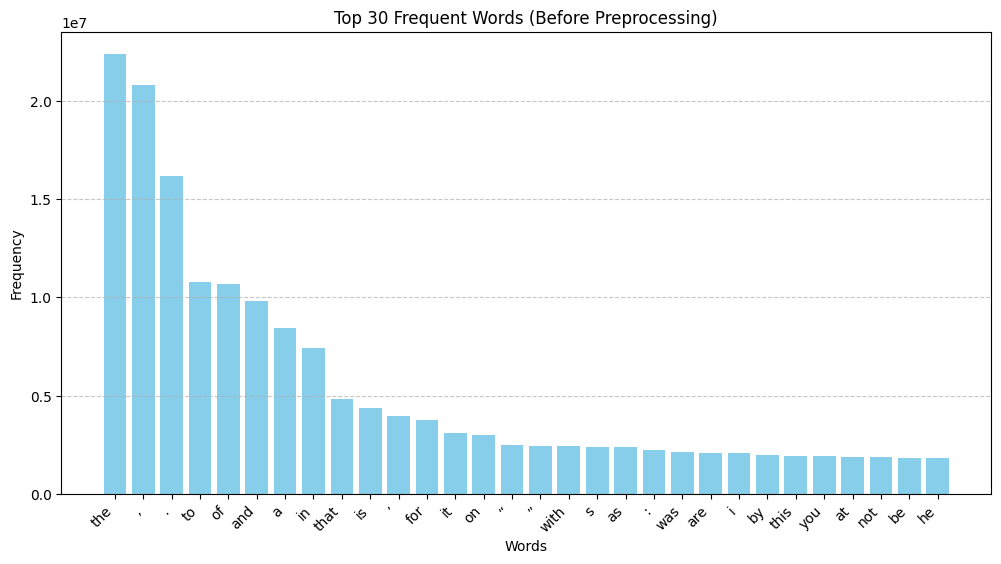

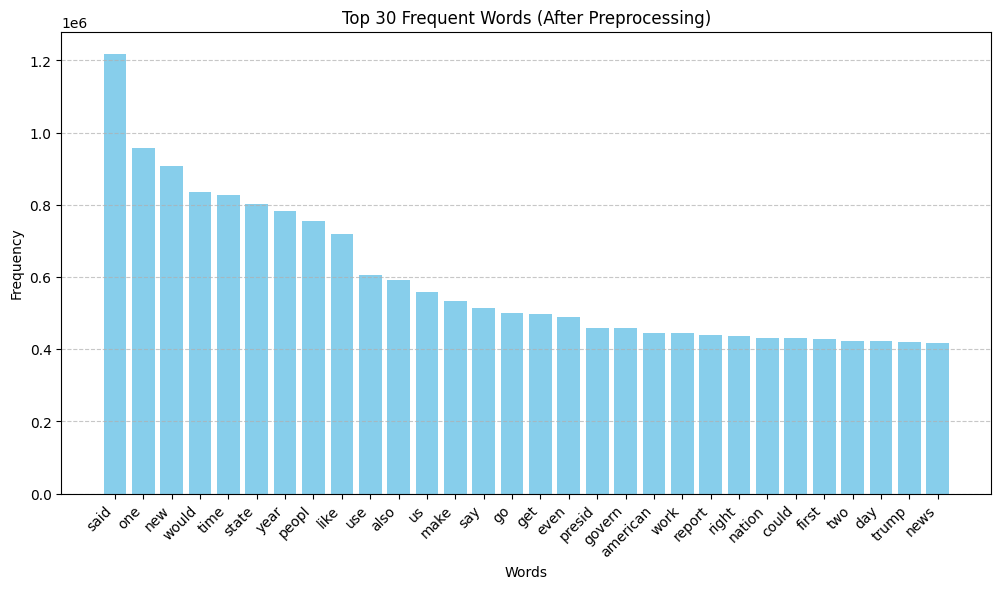

In [18]:
import matplotlib.pyplot as plt

# Function to safely plot word frequencies
def plot_word_frequencies(freq_dist, title):
    if not freq_dist or len(freq_dist) == 0:
        print(f"Warning: No words available for {title}")
        return
    
    # Get the top 30 most common words
    most_common_words = freq_dist.most_common(30)
    words, counts = zip(*most_common_words)  # Unzip words and their counts
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a light grid
    plt.show()

# Plotting the 30 most frequent words before preprocessing
plot_word_frequencies(freq_dist_before, "Top 30 Frequent Words (Before Preprocessing)")

# Plotting the 30 most frequent words after preprocessing
plot_word_frequencies(freq_dist, "Top 30 Frequent Words (After Preprocessing)")


In [21]:
from sklearn.model_selection import train_test_split

print(df_sampled.columns)

# Split into 80% train, 20% temp
train_df, temp_df = train_test_split(df_sampled, test_size=0.2, stratify=df_sampled['type'], random_state=42)
# Split temp into 50% validation, 50% test (10% each of total)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['type'], random_state=42)

Index(['content', 'url_count', 'date_count', 'num_count'], dtype='object')


KeyError: 'type'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Example mapping (adjusted based on actual labels)
label_mapping = {
    'fake': 'fake',
    'unreliable': 'fake',
    'clickbait': 'fake',
    'conspiracy': 'fake',
    'bias': 'fake',
    'junksci': 'fake',
    'unknown': 'fake',
    'hate': 'fake',
    'political': 'fake',
    'reliable': 'reliable'
}
df_sampled['binary_label'] = df_sampled['type'].map(label_mapping)

# Convert processed_text back to strings (for TF-IDF)
train_df['text_str'] = train_df['processed_text'].apply(lambda x: ' '.join(x))

# Create pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000)),  # Reduce dimensionality
    ('clf', MultinomialNB())
])

# Train
model.fit(train_df['text_str'], train_df['binary_label'])

# Evaluate on validation set
val_df['text_str'] = val_df['processed_text'].apply(lambda x: ' '.join(x))
y_pred = model.predict(val_df['text_str'])
print(classification_report(val_df['binary_label'], y_pred))